In this notebook various conditions will be compared in order to generate insights into the role of loop extrusion and diffusion on the resolution of sister chromatids.
    
The conditions to be compared will be conditions where <b> cohesin loop extrusion is absent (NIPBL depletion, Scc1 depletion)<b> or <b>cohesin loop extrusion occurs with normal turnover kinetics (G2_WT, CTCF_depletion, Sororin_depletion)<b>
    
    
To compare the influence of increased cohesin loop extrusion with other perturbations, a second notebook will be prepared.
    
Note, in order to more precisely calculate the cis/trans ratio, a larger number of ndistbins are used in the scaling plot calculation (60 rather than 40).
    

In [1]:
import seaborn as sbn
import os
import pairlib.scalings
import pairlib
import bioframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import subprocess
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.ticker as mtick
from scipy.interpolate import interp1d, splev, CubicSpline, PPoly
import scipy.integrate as spi
#import metpy
import pathlib

from ngs import HiCTools as HT

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy import ndimage as ndi
import skimage
from skimage import io, filters, morphology
import glob
import seaborn as sns
from scipy import stats
from scipy.signal import chirp, find_peaks, peak_widths, savgol_filter
import pandas as pd
from pathlib import Path
import scipy.stats


ATTENTION: You need to run a high memory kernel

TODO: Figure out why this des not work for pbgzip!

In [2]:
import shutil
shutil.which('pbgzip')   
shutil.which('lz4c')

#Since pairtools/_fileio.py checks for this
#if shutil.which('pbgzip') is None:
#            raise ValueError({
#                'w':'pbgzip is not found, cannot compress output',
#                'a':'pbgzip is not found, cannot compress output',
#                'r':'pbgzip is not found, cannot decompress input'
#                    }[mode])

'/opt/conda/bin/lz4c'

Remark: I made a copy of ther *pairs.gz into unzip/ (to be save because our gzip version is <1.6 and has no -k flag). And this script now only works with unzipped pairsam files until IT installs pbgzip since in the jupyter kernel will not find the version installed with conda. Or we rewrite Antons tool to use a different bzip. (would be in pairtools/_fileio.py)

Now we will load the data:

In [10]:
pairDir = {"sor_TTAGGC": "/groups/gerlich/experiments/Experiments_005600/005679/paper_merging_replicates/sororin/unzipped/",
           "sor_GATCAG": "/groups/gerlich/experiments/Experiments_005600/005679/paper_merging_replicates/sororin/unzipped/",
           "sor_GCCAAT": "/groups/gerlich/experiments/Experiments_005600/005679/paper_merging_replicates/sororin/unzipped/"
          }


sampleMapping = {"sor_TTAGGC": "Sororin_depletion_rep1",
                 "sor_GATCAG": "Sororin_depletion_rep2",
                 "sor_GCCAAT": "Sororin_depletion_rep3"
                 }


pairs = {}
for barcode, name in sampleMapping.items():
    pairs[name] = {}
    pairs[name]["cis"] = HT.load_pairs(
        os.path.join(pairDir[barcode], f"{barcode}.cis.pairs"))
    pairs[name]["trans"] = HT.load_pairs(
        os.path.join(pairDir[barcode], f"{barcode}.trans.pairs"))






<b>Prepare data for plotting<b>

In [11]:
#ndistbins set to 60 instead of 40 to more accurately calculate the interesection point in cis/trans ratio plots
# downsample pairs --> use this if you have multiple samples
# then pairs needs to be a nested dictionary {sample: {cis: pairFrame, trans:pairFrame}}

downsampled = HT.down_sample_pairs(pairs, distance=1000)

# get chromosome features

hg19_chromsizes = bioframe.fetch_chromsizes('hg19')
arms = HT.get_arms_hg19()

# calculate scaling plots

scs = {sample: {rType: pairlib.scalings.compute_scaling(
       downsampled[sample][rType],
       arms,
       hg19_chromsizes, n_dist_bins=40
       ) for rType in ["cis", "trans"]}
       for sample in downsampled.keys()}


# aggregate scaling plots

sc_agg = {sample: {rType: (scs[sample][rType][0]
                  .groupby(['min_dist', 'max_dist'])
                  .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                  .reset_index())
          for rType in scs[sample].keys()
          } for sample in scs.keys()
          }

# calculate x-Values and contact probability

plotData = {sample: {rType: (np.sqrt(sc_agg[sample][rType].min_dist * sc_agg[sample][rType].max_dist),
            sc_agg[sample][rType].n_pairs / sc_agg[sample][rType].n_bp2)
            for rType in sc_agg[sample].keys()
            } for sample in sc_agg.keys()
                        }


Setup apearance for plots

In [12]:
# colormap for plots
colorMap = {"cis": "gray",
            "trans": "black"}

Plot cis and trans per condition:

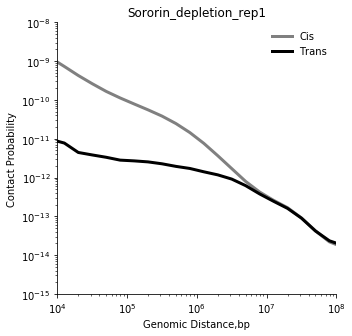

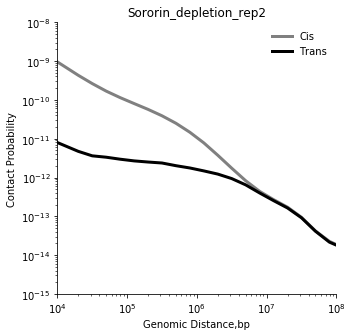

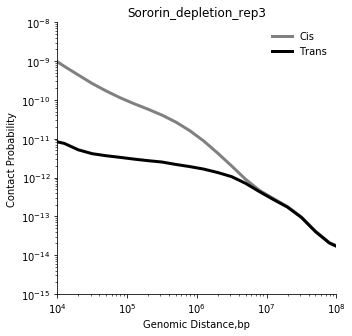

In [13]:
for sample in plotData.keys():
    f, ax = plt.subplots(1,1)
    for rType in ["cis", "trans"]:
        ax.loglog(plotData[sample][rType][0],
                plotData[sample][rType][1],
                label=f'{rType.capitalize()}', color=colorMap[rType], lw=3
                )
    ax.grid(lw=0.5, color='gray')
    ax.grid(False)
    ax.set_xlim(10000, 100000000)
    ax.set_ylim(10**(-15), 10**(-8))
    ax.legend(frameon=False)
    ax.set_xlabel("Genomic Distance,bp")
    ax.set_ylabel("Contact Probability")
    f.set_size_inches(5, 5)
    sbn.despine()
    plt.title(sample)
    f.show()
    #resultsdir = "/groups/gerlich/experiments/Experiments_004800/004885/Results"
    #f.savefig(os.path.join(resultsdir, f"{sample}Scaling_plot.png"), bbox_inches="tight")


In [8]:
#create dataframe from scalings, interpolate the data using cubic spline interpolation and create dataframes as output

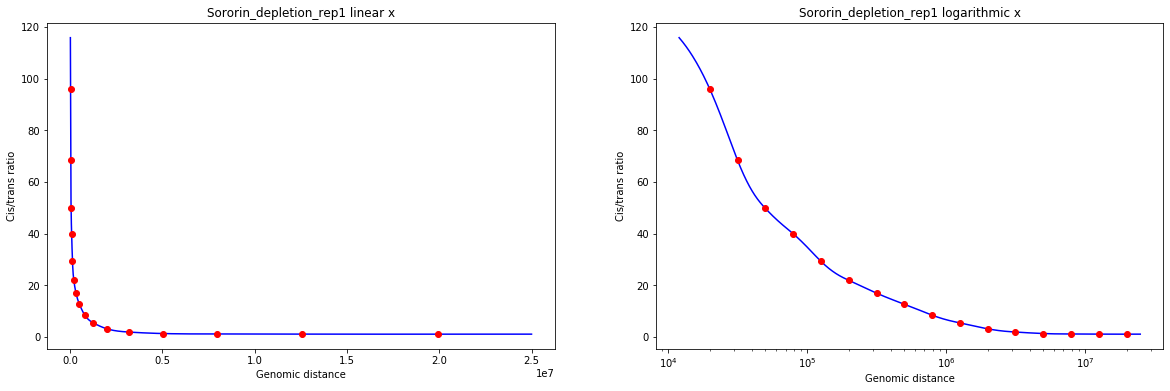

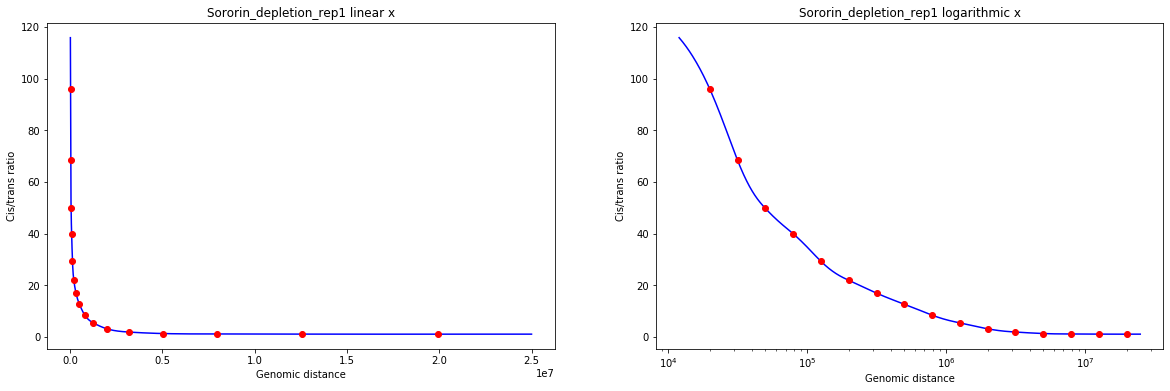

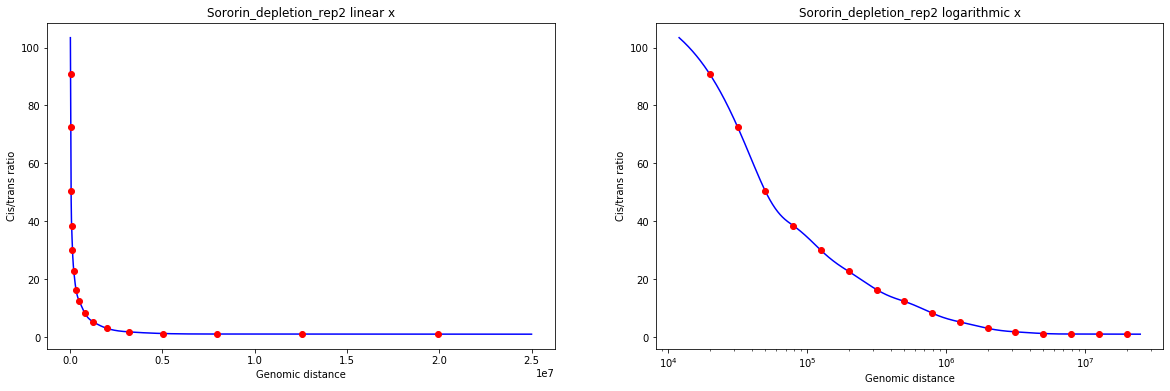

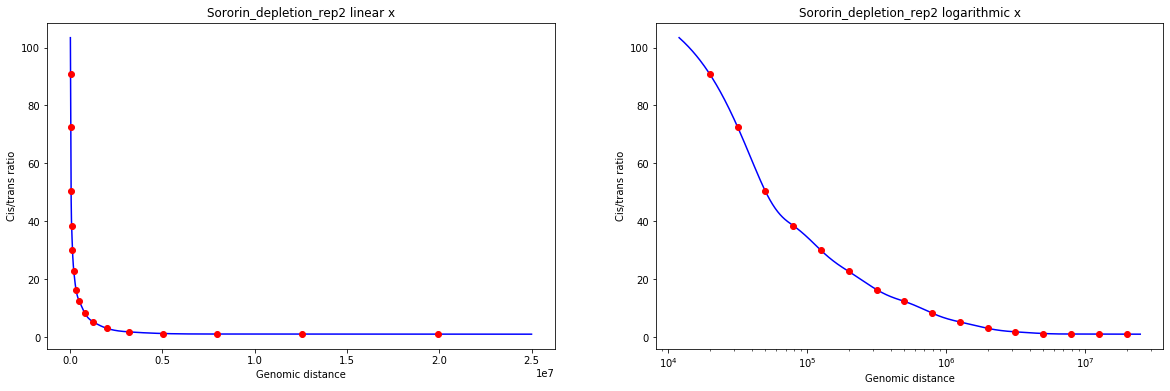

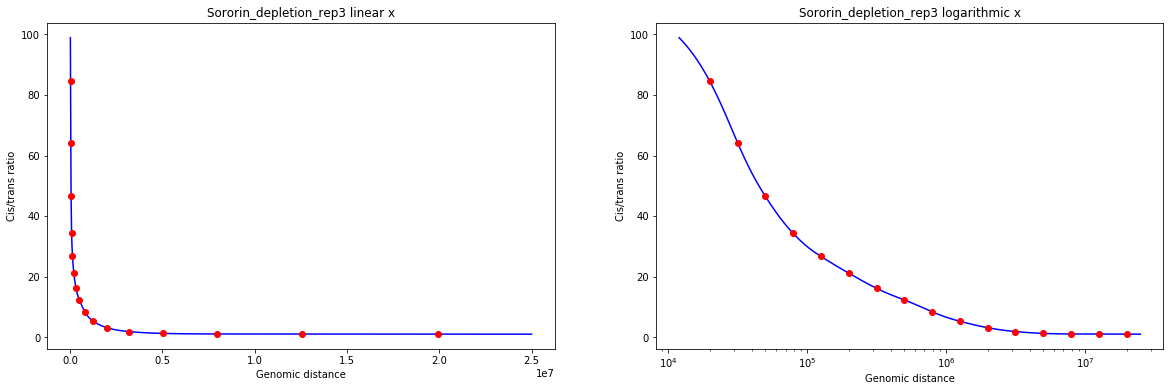

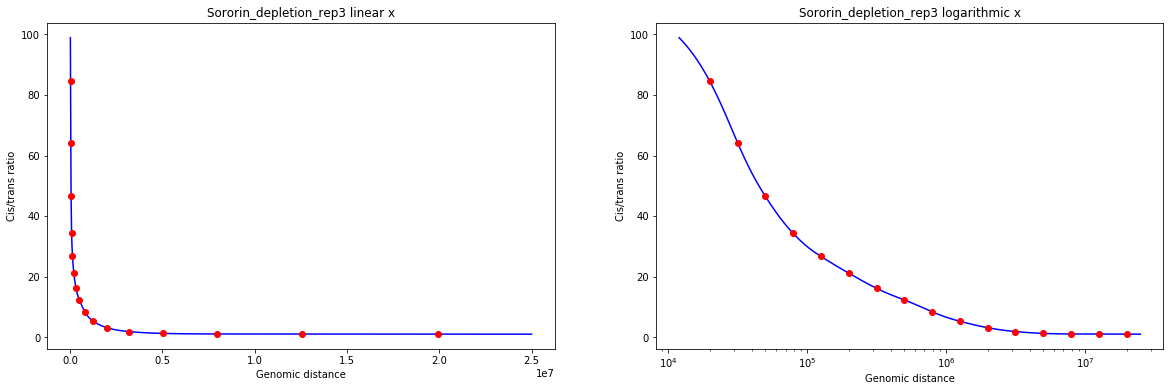

In [14]:
for sample in plotData.keys():
    for rtype in ["cis"], ["trans"]:
        #make dataframes from scalings
        bins = plotData[sample]["cis"][0]
        cis = plotData[sample]["cis"][1]
        trans = plotData[sample]["trans"][1]
        ratio = plotData[sample]["cis"][1]/plotData[sample]["trans"][1]
        series_list = (bins, cis, trans, ratio)
        cis_trans_ratios = pd.concat(series_list, axis=1)
        cis_trans_ratios.columns = ['bins', 'cis_contact_prob', 'trans_contact_prob','cis/trans_ratio']
        cis_trans_ratios["condition"] = f'{sample}'
        #remove last row
        cis_trans_ratios = cis_trans_ratios.iloc[:-1 , :]
        resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/interpolate_values_per_condition/input/3a/"
        cis_trans_ratios.to_csv(os.path.join(resultsdir, f"{sample}.csv"), index=False)
        
               
        #interpolation
        #select all non NaN values
        genomic_distance = cis_trans_ratios.loc[17:32, "bins"]
        ratio = cis_trans_ratios.loc[17:32, "cis/trans_ratio"]
        
        #perform interpolation using cubic spline
        interpolate = CubicSpline(genomic_distance, ratio, bc_type='natural')
        # start value, stop value, number of points to interpolate in between
        genomic_distance_new = np.linspace(12000, 25000000, 100000)
        ratio_new = interpolate(genomic_distance_new)
        ratio_new = savgol_filter(ratio_new, 11, 3)
        #create series to make dataframe        
        series1 = pd.Series(genomic_distance_new)
        series2 = pd.Series(ratio_new)
        series_list = (series1, series2)
        #concatentate series to make a dataframe
        df = pd.concat(series_list, axis=1)
        #rename columns
        df.columns = ['genomic_distance_interpolated','ratio_interpolated']
        df["condition"] = f'{sample}'
        resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/interpolate_values_per_condition/interpolated/3a/"
        df.to_csv(os.path.join(resultsdir, f"{sample}_interpolated_data.csv"), index=False)
        
        #plot data
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
        ax1.set_xlabel('Genomic distance')
        ax1.set_ylabel('Cis/trans ratio')
        ax2.set_xlabel('Genomic distance')
        ax2.set_ylabel('Cis/trans ratio')
        ax1.plot(genomic_distance_new, ratio_new, 'b')
        ax1.plot(genomic_distance, ratio, 'ro')
        ax2.semilogx(genomic_distance_new, ratio_new, 'b')
        ax2.semilogx(genomic_distance, ratio, 'ro')

        ax1.set_title(f"{sample} linear x")
        ax2.set_title(f"{sample} logarithmic x")
        plt.show()
        resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/interpolate_values_per_condition/plots/3a/"
        fig.savefig(os.path.join(resultsdir, f"{sample}_interpolated_data.csv.png"), bbox_inches="tight")
                

In [15]:
#read in interpolated data, get interpolated genomic distance 

In [16]:
#inpath = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig4/interpolate_values/interpolated/3a/"
#extension = 'csv'
#os.chdir(inpath)
#results = glob('*.{}'.format(extension))
#print(results)

In [17]:
#write function to find the first instance where the cis/trans ratio goes below a threshold value
# set threshold value to 1.25

In [24]:
def find_first(threshold, input1, input2):
    #find the first instance where the cis/trans ratio goes below a threshold value
    for i in range(len(input1)):
        if input1[i] < threshold:
            return i-1, input1[i-1], input2[i-1]
    return -1

In [25]:
#for result in results:
    #dataframes = pd.read_csv(result)  

In [26]:
#read in dataframes - pass function to each one and get out the interpolate values
path = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/interpolate_values_per_condition/interpolated/3a/"

csv_files = glob.glob(path + "/*.csv")
### Fetch all files in path

#head, tail = os.path.split(path_lateprophase)
#set up empty lists to append
threshold = 1.25

all_intersect_distance = []
all_condition = []

for file in csv_files:
    split = file.split(os.sep)
    name = split[-1]
    #print (name)
    df = pd.read_csv(file)
    
    #get inputs
    input1 = df["ratio_interpolated"]
    input2 = df["genomic_distance_interpolated"]
    condition_slice = df["condition"]
    condition = condition_slice.iloc[0]
    
    #feed into function
    function = find_first(threshold, input1, input2)
    intersect_distance = function[2]
    #append to lists
    all_intersect_distance.append(intersect_distance)
    all_condition.append(condition)
    
#set results directory
resultsdir = "/groups/gerlich/members/PaulBatty/Paper_preparation/figures/dropbox/fig5/interpolate_values_per_condition/"

#zip the data to make a dataframe
output = pd.DataFrame(list(zip(all_condition, all_intersect_distance)),columns=['condition', 'genomic_distance_intersect'])
final_output = output.set_index(['condition'])
final_output.to_csv(resultsdir + "genomic_distance_intersect.csv")

#final_output.head()

    
    
    
    

In [27]:
final_output

,genomic_distance_intersect
condition,
G2_WT_rep2,2.837921e+06
G2_WT_rep3,2.680245e+06
G2_WT_rep4,2.687242e+06
G2_WT_rep5,2.898893e+06
G2_WT_rep6,2.678746e+06
G2_WT_rep7,2.770453e+06
G2_WT_rep8,2.779699e+06
G2_WT_rep9,2.494833e+06
G2_WT_rep10,2.455601e+06
